# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.20.88:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_500", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620608620,1267390127144248068978361798426155,0.000256,2021-05-10 01:03:40
1,1620608625,1267680042870333742156839070397317,0.000256,2021-05-10 01:03:45
2,1620608735,1267817457383972330861871773689515,0.000256,2021-05-10 01:05:35
3,1620609459,1267594782604196631584143944219246,0.000256,2021-05-10 01:17:39
4,1620609550,1268216030588665931252309527014595,0.000256,2021-05-10 01:19:10
...,...,...,...,...
829000,1636441571,1142082588585671647785500155330124,0.000208,2021-11-09 07:06:11
829001,1636441571,1142071759175866417828744621024494,0.000208,2021-11-09 07:06:11
829002,1636441612,1142000969568059491037541876247525,0.000208,2021-11-09 07:06:52
829003,1636441612,1142013920888200672190989935421715,0.000208,2021-11-09 07:06:52


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:03:40'

# 指标计算

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#之后要扩展回测区间时，需要更新此处的基本行情数据
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min'] 
# df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211118_1440min_v17_E')['1440min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos
datetime,,,,,,,,
2021-05-10 01:03:40,1620608620,1267390127144248068978361798426155,0.000256,False,False,False,False,True
2021-05-10 01:03:45,1620608625,1267680042870333742156839070397317,0.000256,False,False,False,False,True
2021-05-10 01:05:35,1620608735,1267817457383972330861871773689515,0.000256,False,False,False,False,True
2021-05-10 01:17:39,1620609459,1267594782604196631584143944219246,0.000256,False,False,False,False,True
2021-05-10 01:19:10,1620609550,1268216030588665931252309527014595,0.000256,False,False,False,False,True
...,...,...,...,...,...,...,...,...
2021-11-09 07:06:11,1636441571,1142082588585671647785500155330124,0.000208,True,True,False,False,False
2021-11-09 07:06:11,1636441571,1142071759175866417828744621024494,0.000208,True,True,False,False,False
2021-11-09 07:06:52,1636441612,1142000969568059491037541876247525,0.000208,True,True,False,False,False


# 回测

In [4]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.00025589480656772624


# 建池撤池详细信息

In [5]:
import Strategy_usdceth_vol_v2
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol_v2)
strategy = Strategy_usdceth_vol_v2.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  134550716130617999360
price:  0.00025589480656772624
$$$$$$$【Upper Price】: 0.0003299741828129268
$$$$$$$【Lower Price】: 0.00019844628894939335
######【L】:60589815205657352【USDC】:449725000000【ETH】:116954059501133987840
将要投入池子的数量 amount_t0: 449724999999 amount_t1: 116954059501133873152
【RealWorldTime】:2021-05-10 09:03:40, Timestamp: 1620608620, Blocknumber: 12403549
Mint position： Position(L=60578519145560456, tick=[191040, 196140], range=[3035.1064, 5054.2070])
【Mint amount】: token0=449555.945456, token1=116.95405950113387
Wallet amount: token0=169.054544, token1=17.596656629484126
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: True
Price(0.00023776881436293133) out of range(0.00019844628894939335, 0.0003299741828129268)
【RealWorld

******************************************【撤销池子】【原因:超边撤池】******************************************
Price(0.0002777026669412006) out of range(0.00027789770684649706, 0.0004620850770640702)
【RealWorldTime】:2021-09-02 00:10:17,Timestamp: 1630512617, Blocknumber: 13140759
Decreased position： Position(L=0, tick=[194400, 199500], range=[2168.9936, 3611.9138])
【Decreased amount】: token0=1016613.820177, token1=3.5374737501540223
Wallet amount: token0=1016613.820178, token1=41.209922526071246
撤池后经转换 Wallet amount: token0=1193578.295454, token1=2.3135386372997178
**********************【Price Over MA】【创建Long Vol池子】【第8次建池】***********************************
转换后钱包中余额 amount0:  536781998924.0 amount1:  184889546253355882279
price:  0.00027777190305529656
$$$$$$$【Upper Price】: 0.00035818451319294175
$$$$$$$【Lower Price】: 0.00021541196585849904
######【L】:76481644679614640【USDC】:536781998924【ETH】:152686374428851961856
将要投入池子的数量 amount_t0: 536781998924 amount_t1: 152686374428851961856
【RealWorldTime】:2

# 获取原始绩效

In [6]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x21d259d6d30>,
 2: <univ3api.simulation.PositionReport at 0x21dc9e6bef0>,
 3: <univ3api.simulation.PositionReport at 0x21dc9e934e0>,
 4: <univ3api.simulation.PositionReport at 0x21dc9e8e710>,
 5: <univ3api.simulation.PositionReport at 0x21dc9e8e518>,
 6: <univ3api.simulation.PositionReport at 0x21dc9e8e198>,
 7: <univ3api.simulation.PositionReport at 0x21dc9e8ee80>,
 8: <univ3api.simulation.PositionReport at 0x21dc9e8e898>,
 9: <univ3api.simulation.PositionReport at 0x21dca4d9fd0>,
 10: <univ3api.simulation.PositionReport at 0x21dca4d9be0>,
 11: <univ3api.simulation.PositionReport at 0x21dca4d9f28>}

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-25 06:59:25,420125.748404,0.000000,0.000000,0.000000,196.194,0.000000e+00,0.000000e+00,0.000000e+00
1,2021-07-25 07:00:16,420125.629393,0.000000,0.000000,0.000000,196.194,2.740421e-08,2.740421e-08,2.740421e-08
2,2021-07-25 07:00:24,420125.931751,0.000151,0.000151,0.000151,196.194,0.000000e+00,2.740421e-08,2.740421e-08
3,2021-07-25 07:00:29,420114.170202,0.000000,0.000151,0.000151,196.199,2.708300e-06,2.735704e-06,2.735704e-06
4,2021-07-25 07:01:58,418722.682748,0.000000,0.000151,0.000151,196.84,3.205414e-04,3.232771e-04,3.232771e-04
...,...,...,...,...,...,...,...,...,...
266,2021-07-25 07:58:25,432428.560670,0.000000,15.280177,15.280177,190.548,4.018878e-06,4.208497e-03,4.208497e-03
267,2021-07-25 07:58:28,432437.688586,0.004563,15.284740,15.284740,190.543,0.000000e+00,4.208497e-03,4.208497e-03
268,2021-07-25 07:59:24,432760.473101,0.161392,15.446132,15.446132,190.396,0.000000e+00,4.208497e-03,4.208497e-03
269,2021-07-25 07:59:24,432490.575188,0.000000,15.446132,15.446132,190.519,6.171120e-05,4.270208e-03,4.270208e-03


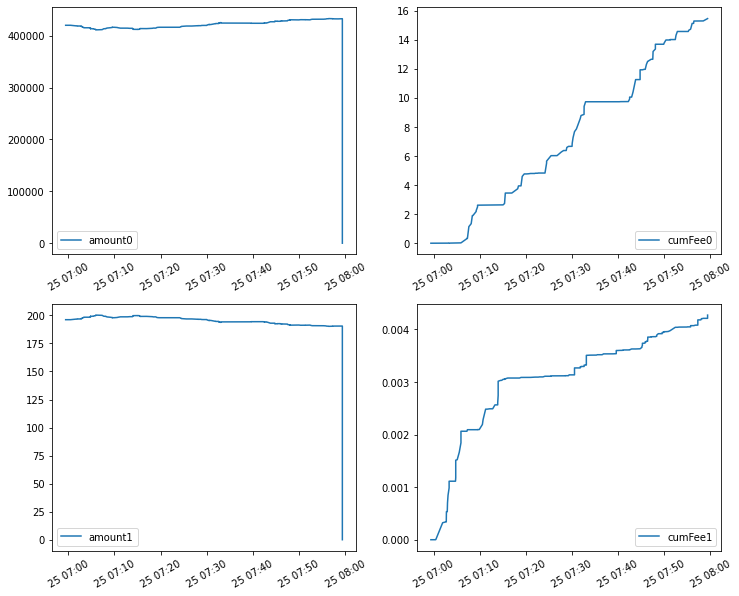

In [7]:
positions[5].get_balance(plain=True, draw_plot=True)

In [8]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:title={'center':'Total Balance'}>

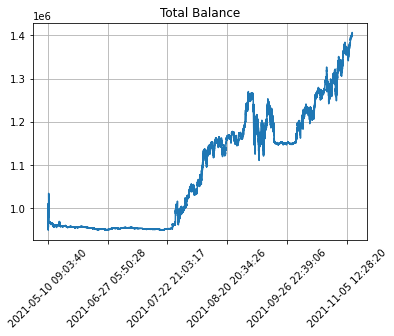

In [9]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True,title='Total Balance')
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [10]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620608620,525804.794303
1620608625,526430.619898
1620608735,526727.030108
1620609459,526246.970823
1620609550,527586.308840
...,...
1636441469,475875.194116
1636441482,475855.263490
1636441498,475823.946355


In [11]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620608620,449725.000000
1620608625,448858.935899
1620608735,448448.576428
1620609459,449113.924941
1620609550,447259.157141
...,...
1636441469,927590.599098
1636441482,927619.310291
1636441498,927653.404287


In [12]:
tb_Timing

2021-05-10 09:03:40    9.755298e+05
2021-05-10 09:03:45    9.752896e+05
2021-05-10 09:05:35    9.751756e+05
2021-05-10 09:17:39    9.753609e+05
2021-05-10 09:19:10    9.748455e+05
                           ...     
2021-11-09 15:04:29    1.403466e+06
2021-11-09 15:04:42    1.403475e+06
2021-11-09 15:04:58    1.403477e+06
2021-11-09 15:06:11    1.403487e+06
2021-11-09 15:06:52    1.403555e+06
Length: 509255, dtype: float64

# 计算绩效指标

In [13]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.007281e+06
2021-05-11    9.920798e+05
2021-05-12    1.014597e+06
2021-05-13    9.660461e+05
2021-05-14    9.678366e+05
                  ...     
2021-11-05    1.360420e+06
2021-11-06    1.351570e+06
2021-11-07    1.379768e+06
2021-11-08    1.398675e+06
2021-11-09    1.403555e+06
Freq: D, Length: 184, dtype: float64

In [14]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb

,close,return,return_2
2021-05-10,1.007281e+06,NaN,NaN
2021-05-11,9.920798e+05,-0.015091,-0.015091
2021-05-12,1.014597e+06,0.022696,0.022696
2021-05-13,9.660461e+05,-0.047852,-0.047852
2021-05-14,9.678366e+05,0.001853,0.001853
...,...,...,...
2021-11-05,1.360420e+06,-0.001320,-0.001320
2021-11-06,1.351570e+06,-0.006505,-0.006505
2021-11-07,1.379768e+06,0.020863,0.020863
2021-11-08,1.398675e+06,0.013703,0.013703


<AxesSubplot:>

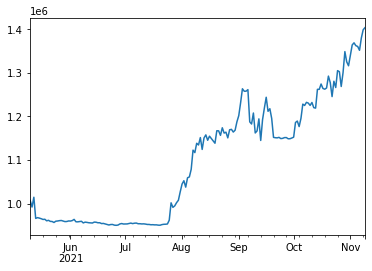

In [15]:
df_tb['close'].plot()

In [16]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_USDC_WETH_500】

USDC手续费 35061.940632 ETH手续费(USDC计价) 43972.210961109835
***************************资金曲线绩效***************************
最大回撤 0.09379164132714746
最长回撤持续期 79 日 起始日期 2021-05-12 00:00:00 结束日期 2021-07-30 00:00:00
年化收益 0.9380737159511399
夏普比率 3.457436403150978
卡尔玛比率 10.001677150302942


<AxesSubplot:title={'center':'Total Balance'}>

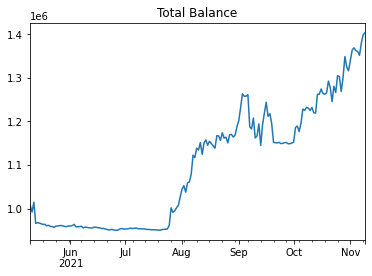

In [17]:
print('【SWAP_USDC_WETH_500】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')

In [18]:
annualReturnNoneStrategy50 = 0.20490032648956236
annualReturnNoneStrategy100 = 0.35132285730195645
annualRetrunStrategy = 0.9380737159511399
print('相对Case_usdceth_none_500_50per年化',annualRetrunStrategy - annualReturnNoneStrategy50)
print('相对Case_usdceth_none_500_100per年化',annualRetrunStrategy - annualReturnNoneStrategy100)

相对Case_usdceth_none_500_50per年化 0.7331733894615775
相对Case_usdceth_none_500_100per年化 0.5867508586491834
